# Amazon Cell Phone Review - Sentiment Analysis
# using NLP 
Analyzing the Amazon cellphone dataset and building classification models to predict if the sentiment of a given input sentence is positive or negative.

### Importing required libraries

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Exploratory Data Analysis

In [8]:
#Load the data

data = pd.read_csv(r"C:/Users/Admin/Downloads/archive/20191226-reviews.csv")

print(f"Dataset shape : {data.shape}")

Dataset shape : (67986, 8)


In [10]:
data.head()

,asin,name,rating,date,verified,title,body,helpfulVotes
0,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0
1,B0000SX2UC,Luke Wyatt,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0
2,B0000SX2UC,Brooke,5,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0
3,B0000SX2UC,amy m. teague,3,"March 18, 2004",False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0
4,B0000SX2UC,tristazbimmer,4,"August 28, 2005",False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0


In [12]:
#Column names

print(f"Feature names : {data.columns.values}")

Feature names : ['asin' 'name' 'rating' 'date' 'verified' 'title' 'body' 'helpfulVotes']


In [14]:
#Check for null values

data.isnull().sum()

asin                0
name                3
rating              0
date                0
verified            0
title              29
body               26
helpfulVotes    40771
dtype: int64

There are many null values in this data file that needs to be removed.

In [17]:
#Getting the record where 'verified_reviews' is null 

data[data['helpfulVotes'].isna() == True]

,asin,name,rating,date,verified,title,body,helpfulVotes
5,B0000SX2UC,J. White,4,"September 25, 2005",False,Worked great for me,"Hello, I have this phone and used it until I d...",NaN
14,B0009N5L7K,Marcel Thomas,1,"March 5, 2016",True,Stupid phone,DON'T BUY OUT OF SERVICE,NaN
15,B0009N5L7K,William B.,4,"February 9, 2006",False,Exellent Service,I have been with nextel for nearly a year now ...,NaN
16,B0009N5L7K,K. Mcilhargey,5,"February 7, 2006",False,I love it,"I just got it and have to say its easy to use,...",NaN
17,B0009N5L7K,Stephen Cahill,1,"December 20, 2016",True,Phones locked,1 star because the phones locked so I have to ...,NaN
...,...,...,...,...,...,...,...,...
67976,B081H6STQQ,Eduardo T.,5,"August 11, 2019",True,Love it,Best phone from Sony so far,NaN
67977,B081H6STQQ,Dean,5,"July 23, 2019",True,that it works,"I love it for what I use it for, the battery l...",NaN
67983,B081H6STQQ,simon,5,"July 14, 2019",False,"great phon3, but many bugs need to fix. still ...",buy one more for my cousin,NaN
67984,B081TJFVCJ,Tobiasz Jedrysiak,5,"December 24, 2019",True,Phone is like new,Product looks and works like new. Very much re...,NaN


In [19]:
#We will drop the null record

data.dropna(inplace=True)

In [21]:
print(f"Dataset shape after dropping null values : {data.shape}")

Dataset shape after dropping null values : (27203, 8)


In [23]:
#Creating a new column 'length' that will contain the length of the string in 'verified_reviews' column

data['length'] = data['title'].apply(len)

In [25]:
data.head()

,asin,name,rating,date,verified,title,body,helpfulVotes,length
0,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0,27
1,B0000SX2UC,Luke Wyatt,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0,27
2,B0000SX2UC,Brooke,5,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0,15
3,B0000SX2UC,amy m. teague,3,"March 18, 2004",False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0,23
4,B0000SX2UC,tristazbimmer,4,"August 28, 2005",False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0,44


The 'length' column is new generated column - stores the length of 'title' for that record. Let's check for some sample records

In [28]:
#Randomly checking for 10th record

print(f"'title' column value: {data.iloc[10]['title']}") #Original value
print(f"Length of review : {len(data.iloc[10]['title'])}") #Length of review using len()
print(f"'length' column value : {data.iloc[10]['length']}") #Value of the column 'length'

'title' column value: Slow, annoying, fragile, heavy, and bulky...
Length of review : 44
'length' column value : 44


We can see that the length of review is the same as the value in the length column for that record

Datatypes of the features

In [32]:
data.dtypes

asin             object
name             object
rating            int64
date             object
verified           bool
title            object
body             object
helpfulVotes    float64
length            int64
dtype: object

* rating, verified and length are integer values <br>
* asin, name and title are string values

### Analyzing 'rating' column

This column refers to the rating of the variation given by the user

In [36]:
len(data)

27203

In [38]:
#Distinct values of 'rating' and its count  

print(f"Rating value count: \n{data['rating'].value_counts()}")

Rating value count: 
rating
5    12957
1     7061
4     3280
3     2032
2     1873
Name: count, dtype: int64


Let's plot the above values in a bar graph

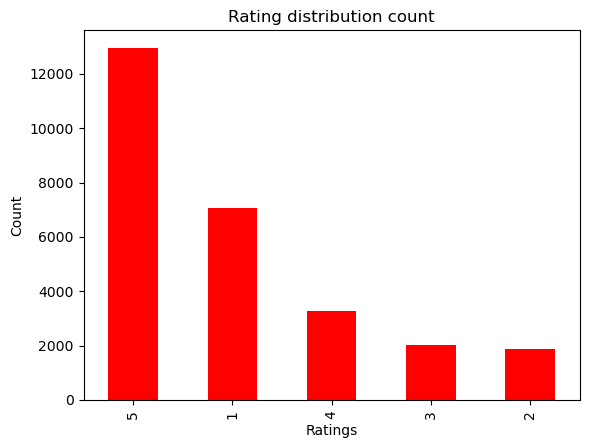

In [41]:
#Bar plot to visualize the total counts of each rating

data['rating'].value_counts().plot.bar(color = 'red')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [43]:
#Finding the percentage distribution of each rating - we'll divide the number of records for each rating by total number of records

print(f"Rating value count - percentage distribution: \n{round(data['rating'].value_counts()/data.shape[0]*100,2)}")

Rating value count - percentage distribution: 
rating
5    47.63
1    25.96
4    12.06
3     7.47
2     6.89
Name: count, dtype: float64


Let's plot the above values in a pie chart

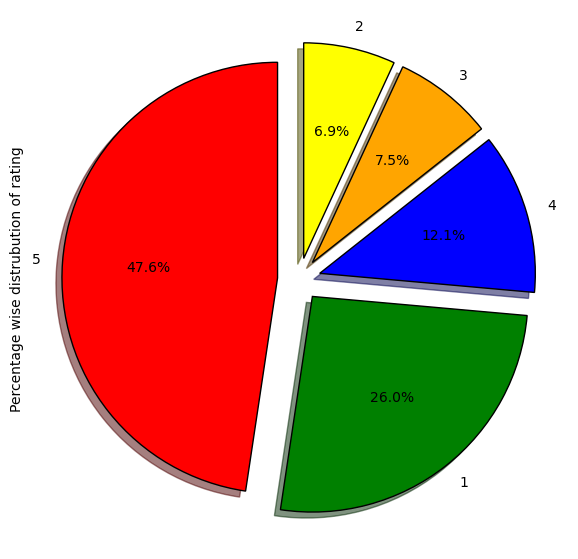

In [46]:
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green', 'blue','orange','yellow')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['rating'].value_counts()/data.shape[0]

explode=(0.1,0.1,0.1,0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of rating')

from io import  BytesIO

graph = BytesIO()

fig.savefig(graph, format="png")

### Analyzing 'verified' column

This column refers to the feedback of the verified review

In [49]:
# this column is further cleaned and stores 1 for rating greater than 0 and 0 for rating less than zero.
# Define positive and negative reviews based on rating thresholds
data['verified'] = data['rating'].apply(lambda x: True if x >= 4 else False)


In [51]:
# change the type of the data provided for further data processing.
data['verified'] = data['verified'].astype(int)


In [53]:
data.dtypes

asin             object
name             object
rating            int64
date             object
verified          int32
title            object
body             object
helpfulVotes    float64
length            int64
dtype: object

In [55]:
#Distinct values of 'verified' and its count 

print(f"Feedback value count: \n{data['verified'].value_counts()}")

Feedback value count: 
verified
1    16237
0    10966
Name: count, dtype: int64


There are 2 distinct values of 'feedback' present - 0 and 1. Let's see what kind of review each value corresponds to.

In [58]:
#Extracting the 'title' value for one record with verified = 0

review_0 = data[data['verified'] == 0].iloc[1]['title']
print(review_0)

Text Messaging Doesn't Work


In [60]:
#Extracting the 'title' value for one record with verified = 1

review_1 = data[data['verified'] == 1].iloc[1]['title']
print(review_1)

Great phone service and options, lousy case!


From the above 2 examples we can see that feedback **0 is negative review** and **1 is positive review**

Let's plot the feedback value count in a bar graph

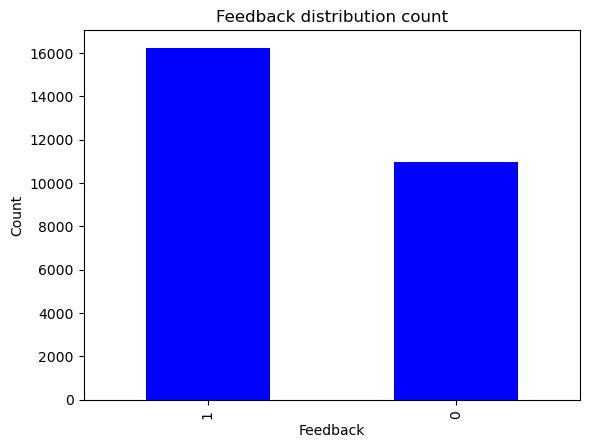

In [63]:
#Bar graph to visualize the total counts of each feedback

data['verified'].value_counts().plot.bar(color = 'blue')
plt.title('Feedback distribution count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

In [65]:
#Finding the percentage distribution of each feedback - we'll divide the number of records for each feedback by total number of records

print(f"Feedback value count - percentage distribution: \n{round(data['verified'].value_counts()/data.shape[0]*100,2)}")

Feedback value count - percentage distribution: 
verified
1    59.69
0    40.31
Name: count, dtype: float64


Feedback distribution <br>
* 59.69% reviews are positive <br>
* 40.31% reviews are negative

<Axes: ylabel='Percentage wise distrubution of feedback'>

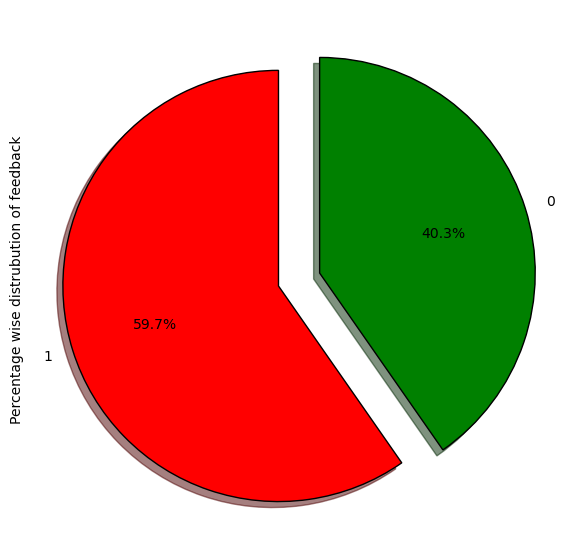

In [68]:
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['verified'].value_counts()/data.shape[0]

explode=(0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of feedback')

Let's see the 'rating' values for different values of 'verified'

In [71]:
#verified = 0
data[data['verified'] == 0]['rating'].value_counts()

rating
1    7061
3    2032
2    1873
Name: count, dtype: int64

In [73]:
#verified = 1
data[data['verified'] == 1]['rating'].value_counts()

rating
5    12957
4     3280
Name: count, dtype: int64

##### If rating of a review is 1,2  or 3 then the feedback is 0 (negative) and if the rating is 4 or 5 then the feedback is 1 (positive).

### Analyzing 'verfied' column

This column contains the textual review given by the user for a variation for the product.

In [75]:
data['length'].describe()

count    27203.000000
mean        29.041797
std         20.823926
min          1.000000
25%         13.000000
50%         24.000000
75%         40.000000
max        193.000000
Name: length, dtype: float64

Length analysis for full dataset

[Text(0.5, 1.0, 'Distribution of length of review ')]

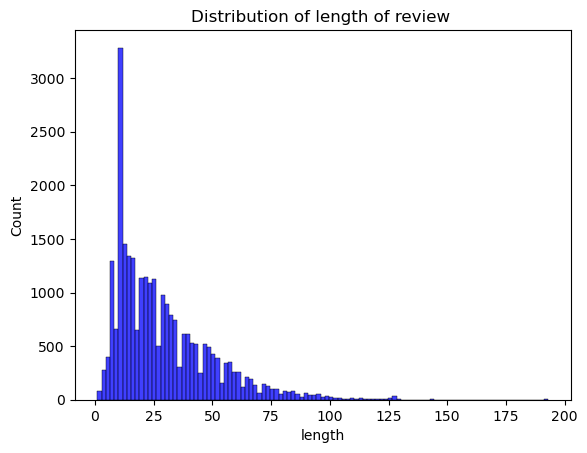

In [77]:
sns.histplot(data['length'],color='blue').set(title='Distribution of length of review ')

Length analysis when feedback is 0 (negative)

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 0')]

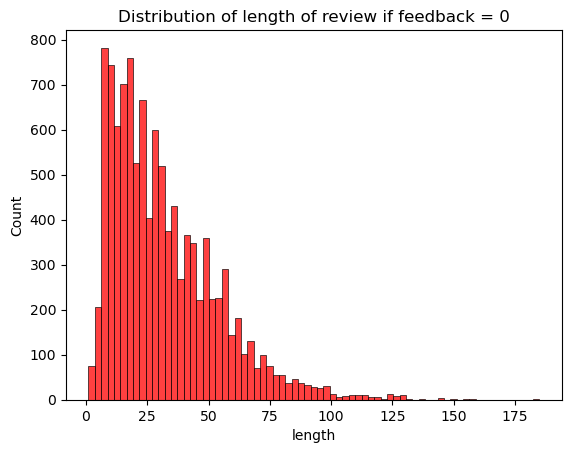

In [79]:
sns.histplot(data[data['verified']==0]['length'],color='red').set(title='Distribution of length of review if feedback = 0')

Length analysis when feedback is 1 (positive)

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 1')]

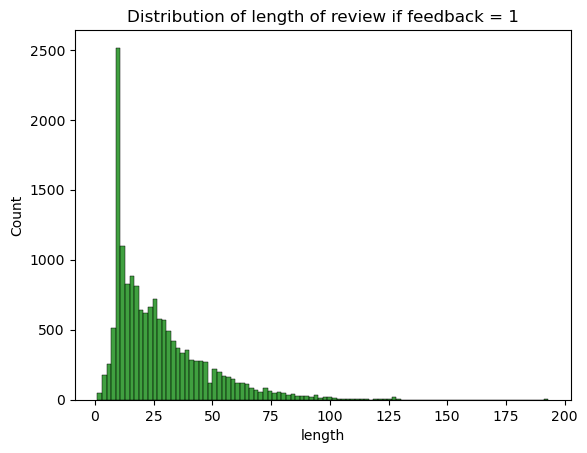

In [81]:
sns.histplot(data[data['verified']==1]['length'],color='green').set(title='Distribution of length of review if feedback = 1')

Lengthwise mean rating

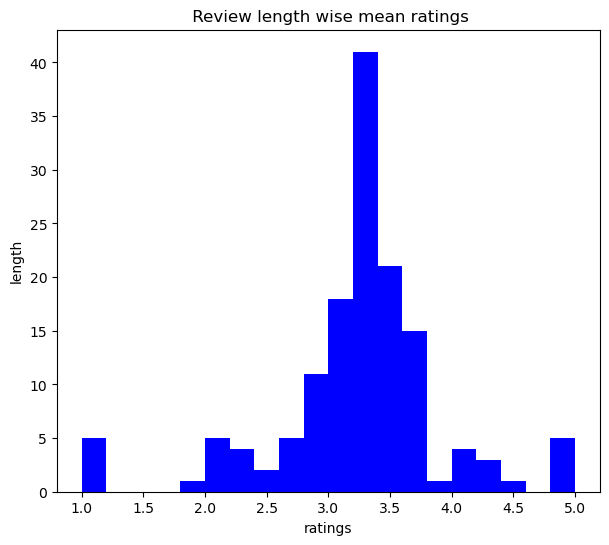

In [83]:
data.groupby('length')['rating'].mean().plot.hist(color = 'blue', figsize=(7, 6), bins = 20)
plt.title(" Review length wise mean ratings")
plt.xlabel('ratings')
plt.ylabel('length')
plt.show()

In [85]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.title)

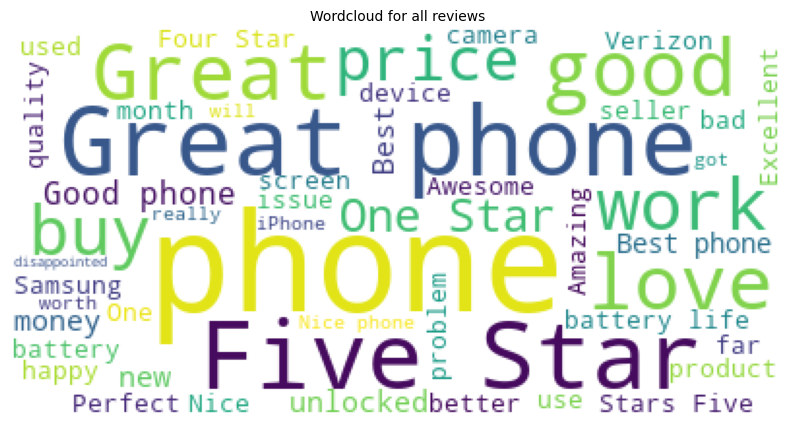

In [87]:
# Combine all reviews
reviews = " ".join([review for review in data['title']])
                        
# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

Lets find the unique words in each feedback category

In [89]:
# Combine all reviews for each feedback category and splitting them into individual words
neg_reviews = " ".join([review for review in data[data['verified'] == 0]['title']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['verified'] == 1]['title']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)


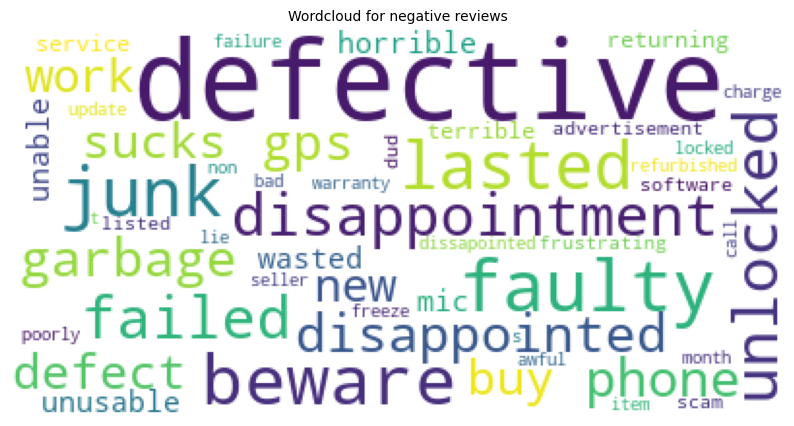

In [90]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

Negative words can be seen in the above word cloud - garbage, pointless, poor, horrible, repair etc

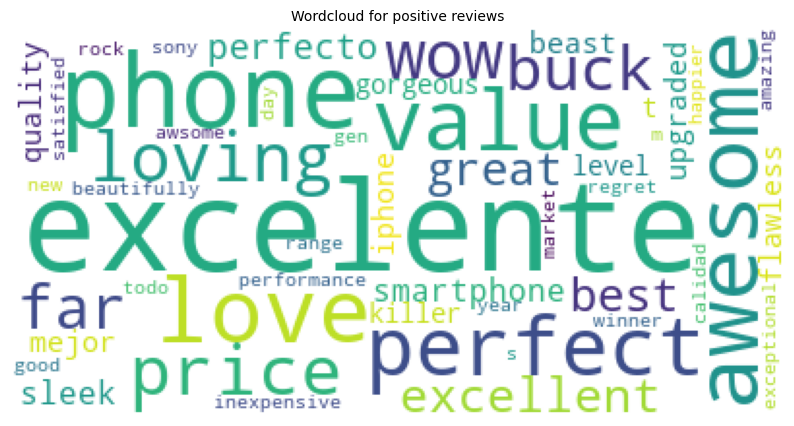

In [92]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

Positive words can be seen in the above word cloud - good, enjoying, amazing, best, great etc

# Preprocessing and Modelling

To build the corpus from the 'verified_reviews' we perform the following - <br>
1. Replace any non alphabet characters with a space
2. Covert to lower case and split into words
3. Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus

In [96]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['title'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

Using Count Vectorizer to create bag of words

In [98]:
cv = CountVectorizer(max_features = 2500)

#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
y = data['verified'].values

In [101]:
import os
import pickle

# Ensure the 'Models' directory exists
os.makedirs('Models', exist_ok=True)

# Now save the CountVectorizer model
pickle.dump(cv, open('Models/countVectorizer.pkl', 'wb'))


Checking the shape of X and y

In [103]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (27203, 2500)
y shape: (27203,)


Splitting data into train and test set with 30% data with testing.

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (19042, 2500)
y train: (19042,)
X test: (8161, 2500)
y test: (8161,)


In [107]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 7
X test max value: 5


We'll scale X_train and X_test so that all values are between 0 and 1.

In [109]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [111]:
import os
import pickle

# Create the 'Models' directory if it doesn't exist
os.makedirs('Models', exist_ok=True)

# Now save the scaler model
pickle.dump(scaler, open('Models/scaler.pkl', 'wb'))


#### Random Forest

In [221]:
#Fitting scaled X_train and y_train on Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [223]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

Training Accuracy : 0.9639743724398697
Testing Accuracy : 0.825634113466487


In [225]:
#Predicting on the test set
y_preds = model_rf.predict(X_test_scl)

In [227]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)

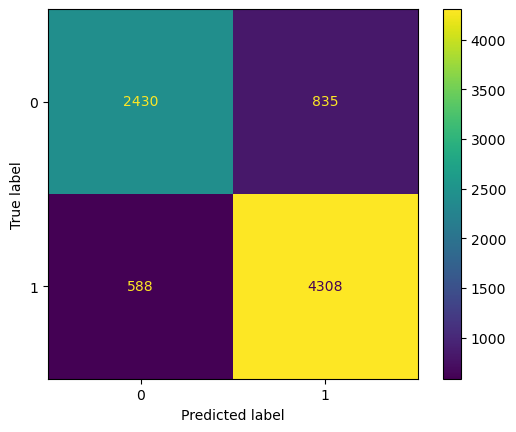

In [229]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

K fold cross-validation

In [232]:
accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.8309525188027967
Standard Variance : 0.00874158784654536


Applying grid search to get the optimal parameters on random forest

In [233]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

In [236]:
cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = model_rf, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scl, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [238]:
#Getting the best parameters from the grid search


print("Best Parameter Combination : {}".format(grid_search.best_params_))

Best Parameter Combination : {'bootstrap': True, 'max_depth': 100, 'min_samples_split': 12, 'n_estimators': 100}


In [240]:
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_preds))

Cross validation mean accuracy on train set : 89.77982879949586
Cross validation mean accuracy on test set : 81.4357735531982
Accuracy score for test set : 0.825634113466487


#### Decision Tree Classifier

In [242]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, y_train)

DecisionTreeClassifier()

In [243]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_dt.score(X_train_scl, y_train))
print("Testing Accuracy :", model_dt.score(X_test_scl, y_test))

Training Accuracy : 0.9639743724398697
Testing Accuracy : 0.8008822448229383


In [244]:
y_preds = model_dt.predict(X_test)

In [245]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[2346  919]
 [ 776 4120]]


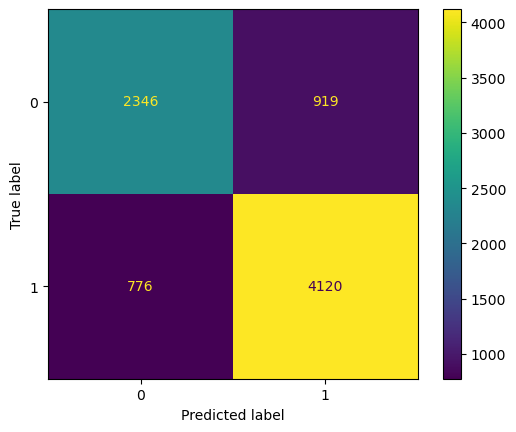

In [246]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_dt.classes_)
cm_display.plot()
plt.show()

## XgBoost

In [113]:
from xgboost import XGBClassifier
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [115]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy :", model_xgb.score(X_test_scl, y_test))

Training Accuracy : 0.8255435353429261
Testing Accuracy : 0.8110525670873667


In [117]:
y_preds = model_xgb.predict(X_test)

In [119]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[2687  578]
 [ 965 3931]]


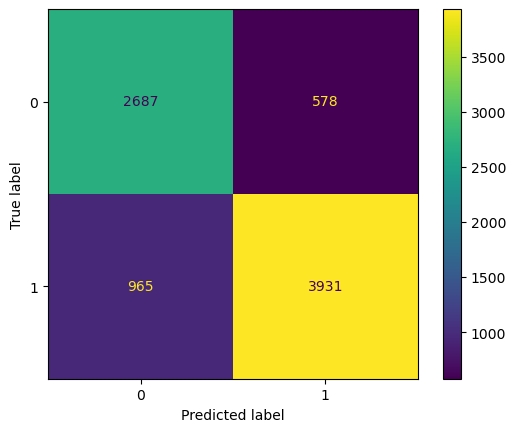

In [121]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [123]:
#Saving the XGBoost classifier
pickle.dump(model_xgb, open('Models/model_xgb.pkl', 'wb'))